This notebook provides examples to go along with the [textbook](http://underactuated.csail.mit.edu/trajopt.html).  I recommend having both windows open, side-by-side!

[Click here](http://underactuated.csail.mit.edu/drake.html#notebooks) for instructions on how to run the notebook on Deepnote and/or Google Colab.

In [1]:
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pydot
from IPython.display import HTML, SVG, clear_output, display
from pydrake.all import (Binding, Box, DiagramBuilder, DirectCollocation,
                         DirectTranscription,
                         FiniteHorizonLinearQuadraticRegulatorOptions,
                         GraphOfConvexSets, GurobiSolver, HPolyhedron,
                         L2NormCost, LinearSystem, LogVectorOutput,
                         MakeFiniteHorizonLinearQuadraticRegulator,
                         MakeFirstAvailableSolver, MathematicalProgram,
                         MosekSolver, MultibodyPlant,
                         MultibodyPositionToGeometryPose, Parser,
                         PiecewisePolynomial, PlanarSceneGraphVisualizer,
                         Point, PointCloud, Rgba, RigidTransform,
                         RotationMatrix, SceneGraph, Simulator, Solve, Sphere,
                         StartMeshcat, TrajectorySource, Variable, eq)
from pydrake.examples.acrobot import AcrobotGeometry, AcrobotPlant
from pydrake.examples.pendulum import PendulumPlant, PendulumState

from underactuated import FindResource, running_as_notebook
from underactuated.jupyter import AdvanceToAndVisualize
from underactuated.meshcat_utils import draw_points, set_planar_viewpoint
from underactuated.pendulum import PendulumVisualizer


In [2]:
# Start the visualizer (run this cell only once, each instance consumes a port)
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7002


# Trajectory optimization for the double integrator

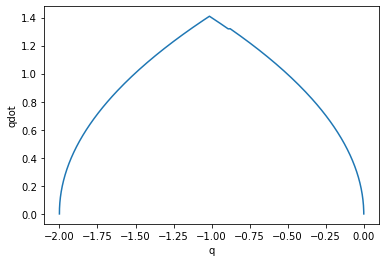

In [3]:
def double_integrator():
    # Discrete-time approximation of the double integrator.
    dt = 0.01;
    A = np.eye(2) + dt*np.mat('0 1; 0 0')
    B = dt*np.mat('0; 1')

    prog = MathematicalProgram()

    N = 284  # Note: I had to do a manual "line search" to find this.

    # Create decision variables
    u = np.empty((1, N-1), dtype=Variable)
    x = np.empty((2, N), dtype=Variable)
    for n in range(N-1):
        u[:,n] = prog.NewContinuousVariables(1, 'u' + str(n))
        x[:,n] = prog.NewContinuousVariables(2, 'x' + str(n))
    x[:,N-1] = prog.NewContinuousVariables(2, 'x' + str(N))

    # Add constraints
    x0 = [-2, 0]
    prog.AddBoundingBoxConstraint(x0, x0, x[:,0])
    for n in range(N-1):
        # Will eventually be prog.AddConstraint(x[:,n+1] == A@x[:,n] + B@u[:,n])
        # See drake issues 12841 and 8315
        prog.AddConstraint(eq(x[:,n+1],A.dot(x[:,n]) + B.dot(u[:,n])))
        prog.AddBoundingBoxConstraint(-1, 1, u[:,n])
    xf = [0, 0]
    prog.AddBoundingBoxConstraint(xf, xf, x[:, N-1])

    result = Solve(prog)

    x_sol = result.GetSolution(x)
    assert(result.is_success()), "Optimization failed"

    plt.figure()
    plt.plot(x_sol[0,:], x_sol[1,:])
    plt.xlabel('q')
    plt.ylabel('qdot');

double_integrator()

## Trajectory optimization using the DirectTranscription class

Because this pattern of making decision variables that are indexed over time, adding the dynamic constraints, defining the running cost and constraints, is so common, we have wrappers in drake on top of `MathematicalProgram` which handle these details for you.

The optimization below is identical to the example above, but using this helper class.

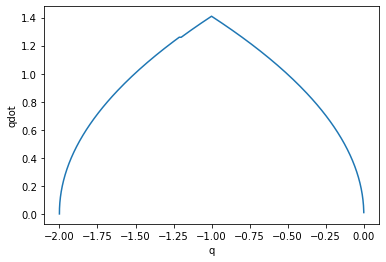

In [4]:
def dirtran_example():
    # Discrete-time approximation of the double integrator.
    dt = 0.01;
    A = np.eye(2) + dt*np.mat('0 1; 0 0')
    B = dt*np.mat('0; 1')
    C = np.eye(2)
    D = np.zeros((2,1))
    sys = LinearSystem(A, B, C, D, dt)

    N = 284
    x0 = [-2, 0]
    xf = [0, 0]

    dirtran = DirectTranscription(sys, sys.CreateDefaultContext(), N)
    prog = dirtran.prog()
    prog.AddBoundingBoxConstraint(x0, x0, dirtran.initial_state())
    prog.AddBoundingBoxConstraint(xf, xf, dirtran.final_state())
    dirtran.AddConstraintToAllKnotPoints(dirtran.input()[0] <= 1)
    dirtran.AddConstraintToAllKnotPoints(dirtran.input()[0] >= -1)

    result = Solve(prog)
    x_sol = dirtran.ReconstructStateTrajectory(result)
    assert(result.is_success()), "Optimization failed"

    plt.figure()
    x_values = x_sol.vector_values(x_sol.get_segment_times())

    plt.plot(x_values[0,:], x_values[1,:])
    plt.xlabel('q')
    plt.ylabel('qdot')

dirtran_example()

One thing that I'm very proud of (it was a lot of work!) is the fact that drake is often smart enough to introspect your system, costs, and constraints and understand whether you have formulated a convex problem or a non-convex one.  The optimization above calls a convex optimization solver.  But if you had passed in a nonlinear system instead, it would have switched to calling a solver that supports nonlinear programming.

# Direct Collocation for the Pendulum

In [5]:
def pend_dircol():
    plant = PendulumPlant()
    context = plant.CreateDefaultContext()

    N = 21
    max_dt = 0.5
    max_tf = N * max_dt
    dircol = DirectCollocation(plant,
                            context,
                            num_time_samples=N,
                            minimum_timestep=0.05,
                            maximum_timestep=max_dt)
    prog = dircol.prog()

    dircol.AddEqualTimeIntervalsConstraints()

    torque_limit = 3.0  # N*m.
    u = dircol.input()
    dircol.AddConstraintToAllKnotPoints(-torque_limit <= u[0])
    dircol.AddConstraintToAllKnotPoints(u[0] <= torque_limit)

    initial_state = PendulumState()
    initial_state.set_theta(0.0)
    initial_state.set_thetadot(0.0)
    prog.AddBoundingBoxConstraint(initial_state.get_value(),
                                  initial_state.get_value(),
                                  dircol.initial_state())
    # More elegant version is blocked on drake #8315:
    # dircol.AddLinearConstraint(
    #     dircol.initial_state() == initial_state.get_value())

    final_state = PendulumState()
    final_state.set_theta(np.pi)
    final_state.set_thetadot(0.0)
    prog.AddBoundingBoxConstraint(final_state.get_value(),
                                  final_state.get_value(), dircol.final_state())
    # dircol.AddLinearConstraint(dircol.final_state() == final_state.get_value())

    R = 10  # Cost on input "effort".
    dircol.AddRunningCost(R * u[0]**2)

    initial_x_trajectory = PiecewisePolynomial.FirstOrderHold(
        [0., 4.], [initial_state.get_value(),
                final_state.get_value()])
    dircol.SetInitialTrajectory(PiecewisePolynomial(), initial_x_trajectory)

    result = Solve(prog)
    assert result.is_success()

    x_trajectory = dircol.ReconstructStateTrajectory(result)

    fig, ax = plt.subplots()

    x_knots = np.hstack([
        x_trajectory.value(t) for t in np.linspace(x_trajectory.start_time(),
                                                x_trajectory.end_time(), 100)
    ])

    ax.set_xlabel('$q$')
    ax.set_ylabel('$\dot{q}$')
    ax.plot(x_knots[0, :], x_knots[1, :])
    display(plt.show())

    # Animate the result.
    vis = PendulumVisualizer(show=False)
    ani = vis.animate(x_trajectory)
    display(HTML(ani.to_jshtml()))

pend_dircol()

AssertionError: 

# Direct Collocation for the Acrobot

Almost identical code works to swing-up the Acrobot.

In [ ]:
def dircol_acrobot():
    plant = AcrobotPlant()
    context = plant.CreateDefaultContext()

    dircol = DirectCollocation(plant,
                            context,
                            num_time_samples=21,
                            minimum_timestep=0.05,
                            maximum_timestep=0.2)
    prog = dircol.prog()

    dircol.AddEqualTimeIntervalsConstraints()

    # Add input limits.
    torque_limit = 8.0  # N*m.
    u = dircol.input()
    dircol.AddConstraintToAllKnotPoints(-torque_limit <= u[0])
    dircol.AddConstraintToAllKnotPoints(u[0] <= torque_limit)

    initial_state = (0., 0., 0., 0.)
    prog.AddBoundingBoxConstraint(initial_state, initial_state,
                                  dircol.initial_state())
    # More elegant version is blocked on drake #8315:
    # dircol.AddLinearConstraint(dircol.initial_state() == initial_state)

    final_state = (np.pi, 0., 0., 0.)
    prog.AddBoundingBoxConstraint(final_state, final_state,
                                  dircol.final_state())
    # dircol.AddLinearConstraint(dircol.final_state() == final_state)

    R = 10  # Cost on input "effort".
    dircol.AddRunningCost(R * u[0]**2)

    # Add a final cost equal to the total duration.
    dircol.AddFinalCost(dircol.time())

    initial_x_trajectory = PiecewisePolynomial.FirstOrderHold(
        [0., 4.], np.column_stack((initial_state, final_state)))  # yapf: disable
    dircol.SetInitialTrajectory(PiecewisePolynomial(), initial_x_trajectory)

    result = Solve(prog)
    assert (result.is_success())

    u_trajectory = dircol.ReconstructInputTrajectory(result)
    times = np.linspace(u_trajectory.start_time(), u_trajectory.end_time(), 100)
    u_lookup = np.vectorize(u_trajectory.value)
    u_values = u_lookup(times)

    plt.figure()
    plt.plot(times, u_values)
    plt.xlabel("time (seconds)")
    plt.ylabel("force (Newtons)")
    display(plt.show())

    x_trajectory = dircol.ReconstructStateTrajectory(result)
    u_trajectory = dircol.ReconstructInputTrajectory(result)

    builder = DiagramBuilder()
    source = builder.AddSystem(TrajectorySource(x_trajectory))
    scene_graph = builder.AddSystem(SceneGraph())
    AcrobotGeometry.AddToBuilder(builder, source.get_output_port(0),
                                 scene_graph)
    visualizer = builder.AddSystem(
        PlanarSceneGraphVisualizer(scene_graph,
                                   xlim=[-4., 4.],
                                   ylim=[-4., 4.],
                                   show=False))
    builder.Connect(scene_graph.get_query_output_port(),
                    visualizer.get_input_port(0))
    simulator = Simulator(builder.Build())

    # Simulate and animate
    AdvanceToAndVisualize(
        simulator, visualizer,
        x_trajectory.end_time() if running_as_notebook else 0.1)

    return x_trajectory, u_trajectory

x_trajectory, u_trajectory = dircol_acrobot()

## Trajectory stabilization with (finite-horizon) LQR

The visualization above was an animation of the solution trajectory, it was not a simulation!  In fact, if you simulate only the planned torques connected to the Acrobot, then you will see that the trajectory does not follow the planned state trajectory.  The trajectory optimization only satisfies the dynamic constraints to some loose tolerance, and the (open-loop) trajectory is unstable.

To do better, we must stabilizing the planned trajectory with feedback.  We do that here with a finite-horizon LQR design, which takes a time-varying linearization of the plant along the trajectory.

In [ ]:
def finite_horizon_lqr(x_trajectory, u_trajectory):
    options = FiniteHorizonLinearQuadraticRegulatorOptions()
    options.x0 = x_trajectory
    options.u0 = u_trajectory

    builder = DiagramBuilder()
    plant = builder.AddSystem(AcrobotPlant())
    context = plant.CreateDefaultContext()
    Q = np.diag([10.,10.,1.,1.])
    options.Qf = Q
    regulator = builder.AddSystem(
        MakeFiniteHorizonLinearQuadraticRegulator(plant,
                                                  context,
                                                  t0=options.u0.start_time(),
                                                  tf=options.u0.end_time(),
                                                  Q=Q,
                                                  R=np.eye(1),
                                                  options=options))
    builder.Connect(regulator.get_output_port(0), plant.get_input_port(0))
    builder.Connect(plant.get_output_port(0), regulator.get_input_port(0))
    input_logger = LogVectorOutput(regulator.get_output_port(0), builder)
    state_logger = LogVectorOutput(plant.get_output_port(0), builder)

    scene_graph = builder.AddSystem(SceneGraph())
    AcrobotGeometry.AddToBuilder(builder, plant.get_output_port(0), scene_graph)
    visualizer = builder.AddSystem(
        PlanarSceneGraphVisualizer(scene_graph,
                                   xlim=[-4., 4.],
                                   ylim=[-4., 4.],
                                   show=False))
    builder.Connect(scene_graph.get_query_output_port(),
                    visualizer.get_input_port(0))
    diagram = builder.Build()
    simulator = Simulator(diagram)

    # Simulate and animate
    AdvanceToAndVisualize(simulator, visualizer,
                          options.u0.end_time() if running_as_notebook else 0.1)

    fig, ax = plt.subplots(2,1)
    ax[0].plot(options.u0.get_segment_times(),
               options.u0.vector_values(options.u0.get_segment_times()).T)
    input_log = input_logger.FindLog(simulator.get_context())
    ax[0].plot(input_log.sample_times(), input_log.data().T)
    ax[0].legend(('u nominal','u actual'))

    ax[1].plot(options.x0.get_segment_times(),
               options.x0.vector_values(options.x0.get_segment_times()).T, 'b')
    state_log = state_logger.FindLog(simulator.get_context())
    ax[1].plot(state_log.sample_times(), state_log.data().T, 'g')
    ax[1].legend(('x nominal','x actual'))
    display(plt.show())

finite_horizon_lqr(x_trajectory, u_trajectory)

# Direct Collocation for the Cart-Pole

While the previous two examples used equations of motion that we derived and typed in manually, for the Cart-Pole we will use the Drake dynamics engine and visualization via [`MultibodyPlant`](https://drake.mit.edu/doxygen_cxx/classdrake_1_1multibody_1_1_multibody_plant.html) and [`SceneGraph`](https://drake.mit.edu/doxygen_cxx/classdrake_1_1geometry_1_1_scene_graph.html).

In [ ]:
def dircol_cartpole():
    plant = MultibodyPlant(time_step=0.0)
    scene_graph = SceneGraph()
    plant.RegisterAsSourceForSceneGraph(scene_graph)
    file_name = FindResource("models/cartpole.urdf")
    Parser(plant).AddModelFromFile(file_name)
    plant.Finalize()

    context = plant.CreateDefaultContext()
    dircol = DirectCollocation(
        plant,
        context,
        num_time_samples=21,
        minimum_timestep=0.1,
        maximum_timestep=0.4,
        input_port_index=plant.get_actuation_input_port().get_index())
    prog = dircol.prog()

    dircol.AddEqualTimeIntervalsConstraints()

    initial_state = (0., 0., 0., 0.)
    prog.AddBoundingBoxConstraint(initial_state, initial_state,
                                  dircol.initial_state())
    # More elegant version is blocked by drake #8315:
    # prog.AddLinearConstraint(dircol.initial_state() == initial_state)

    final_state = (0., np.pi, 0., 0.)
    prog.AddBoundingBoxConstraint(final_state, final_state,
                                  dircol.final_state())
    # prog.AddLinearConstraint(dircol.final_state() == final_state)

    R = 10  # Cost on input "effort".
    u = dircol.input()
    dircol.AddRunningCost(R * u[0]**2)

    # Add a final cost equal to the total duration.
    dircol.AddFinalCost(dircol.time())

    initial_x_trajectory = PiecewisePolynomial.FirstOrderHold(
        [0., 4.], np.column_stack((initial_state, final_state)))  # yapf: disable
    dircol.SetInitialTrajectory(PiecewisePolynomial(), initial_x_trajectory)

    result = Solve(prog)
    assert result.is_success()

    fig, ax = plt.subplots()

    u_trajectory = dircol.ReconstructInputTrajectory(result)
    times = np.linspace(u_trajectory.start_time(), u_trajectory.end_time(), 100)
    u_lookup = np.vectorize(u_trajectory.value)
    u_values = u_lookup(times)

    ax.plot(times, u_values)
    ax.set_xlabel("time (seconds)")
    ax.set_ylabel("force (Newtons)")
    display(plt.show())

    # Animate the results.
    x_trajectory = dircol.ReconstructStateTrajectory(result)

    # TODO(russt): Add some helper methods to make this workflow cleaner.
    builder = DiagramBuilder()
    source = builder.AddSystem(TrajectorySource(x_trajectory))
    builder.AddSystem(scene_graph)
    pos_to_pose = builder.AddSystem(
        MultibodyPositionToGeometryPose(plant, input_multibody_state=True))
    builder.Connect(source.get_output_port(0), pos_to_pose.get_input_port())
    builder.Connect(pos_to_pose.get_output_port(),
                    scene_graph.get_source_pose_port(plant.get_source_id()))

    visualizer = builder.AddSystem(
        PlanarSceneGraphVisualizer(scene_graph,
                                   xlim=[-2, 2],
                                   ylim=[-1.25, 2],
                                   show=False))
    builder.Connect(scene_graph.get_query_output_port(),
                    visualizer.get_input_port(0))
    simulator = Simulator(builder.Build())

    AdvanceToAndVisualize(
        simulator, visualizer,
        x_trajectory.end_time() if running_as_notebook else 0.1)


dircol_cartpole()

# Trajectory optimization using mixed-integer quadratic programming (MI-Convex optimization)

Note: These examples don't work yet with the open-source solvers.  One needs a Mosek/Gurobi license (TODO: Link to the Drake tutorial for setting up the license on Deepnote).

In [ ]:
mip_solver_available = (MosekSolver().available() and
                        MosekSolver().enabled()) or (GurobiSolver().available()
                                                     and
                                                     GurobiSolver().enabled())

A_bl = np.array([[-1, 0], [0, -1], [1, 0], [0, 1], [1, 1]])
A_br = np.array([[1, 0], [0, -1], [-1, 0], [0, 1], [-1, 1]])
A_tl = np.array([[-1, 0], [0, 1], [1, 0], [0, -1], [1, -1]])
A_tr = np.array([[1, 0], [0, 1], [-1, 0], [0, -1], [-1, -1]])
b = np.array([4, 4, 0, 0, -1])

H_bl = HPolyhedron(A_bl, b)
H_br = HPolyhedron(A_br, b)
H_tl = HPolyhedron(A_tl, b)
H_tr = HPolyhedron(A_tr, b)

def plot_and_interact(meshcat, prog, x, start, goal):

    meshcat.Delete()
    meshcat.DeleteAddedControls()
    meshcat.Set2dRenderMode(xmin=-4, xmax=4, ymin=-4, ymax=4)
    meshcat.SetObject("obstacle", Box(np.sqrt(2), 1, np.sqrt(2)), Rgba(1, 0, 0, 1))
    meshcat.SetTransform("obstacle", RigidTransform(RotationMatrix.MakeYRotation(np.pi/4), [0,2,0]))

    meshcat.SetObject("start", Sphere(.1), Rgba(0, 0, 1, 1))
    meshcat.SetObject("goal", Sphere(.1), Rgba(0, 1, 0, 1))

    x_start = start.evaluator().lower_bound()
    x_goal = goal.evaluator().lower_bound()
    x_sol = np.zeros((x.shape[0],3))
    meshcat.AddSlider("x_start", -4, 4, 0.25, x_start[0])
    meshcat.AddSlider("y_start", -4, -1, 0.25, x_start[1])
    meshcat.AddSlider("x_goal", -4, 4, 0.25, x_goal[0])
    meshcat.AddSlider("y_goal", 1, 4, 0.25, x_goal[1])
    pts = PointCloud(x.shape[0])
    pts.mutable_xyzs()[1,:] = 0

    if not running_as_notebook:
        return

    meshcat.AddButton("Stop")
    while meshcat.GetButtonClicks("Stop") < 1:
        x_start = [meshcat.GetSliderValue("x_start"), meshcat.GetSliderValue("y_start")]
        x_goal = [meshcat.GetSliderValue("x_goal"), meshcat.GetSliderValue("y_goal")]
        start.evaluator().UpdateLowerBound(x_start)
        start.evaluator().UpdateUpperBound(x_start)
        goal.evaluator().UpdateLowerBound(x_goal)
        goal.evaluator().UpdateUpperBound(x_goal)

        result = Solve(prog)
        clear_output(wait=True)
        print(f'Feasible: {result.is_success()}')
        print(f'Cost: {result.get_optimal_cost()}')

        x_sol[:,[0,2]] = result.GetSolution(x)

        meshcat.SetLine("x", x_sol.T, 2.0, Rgba(0,0,1,1))
        meshcat.SetTransform("start", RigidTransform([x_start[0], 0, x_start[1]]))
        meshcat.SetTransform("goal", RigidTransform([x_goal[0], 0, x_goal[1]]))
        pts.mutable_xyzs()[0,:] = x_sol[:,0]
        pts.mutable_xyzs()[2,:] = x_sol[:,2]
        meshcat.SetObject("x_pts", pts, 5.0, rgba=Rgba(0, 0, 1, 1))

        time.sleep(.1)

    meshcat.DeleteAddedControls()

def plot_and_interact_spp(meshcat, G, source, target, relaxation):

    meshcat.Delete()
    meshcat.DeleteAddedControls()
    meshcat.Set2dRenderMode(xmin=-4, xmax=4, ymin=-4, ymax=4)
    meshcat.SetObject("obstacle", Box(np.sqrt(2), 1, np.sqrt(2)), Rgba(1, 0, 0, 1))
    meshcat.SetTransform("obstacle", RigidTransform(RotationMatrix.MakeYRotation(np.pi/4), [0,2,0]))

    meshcat.SetObject("start", Sphere(.1), Rgba(0, 0, 1, 1))
    meshcat.SetObject("goal", Sphere(.1), Rgba(0, 1, 0, 1))

    x_start = source.set().x()
    x_goal = target.set().x()
    x_sol = np.zeros((x_start.shape[0],3))
    meshcat.AddSlider("x_start", -4, 4, 0.25, x_start[0])
    meshcat.AddSlider("y_start", -4, -1, 0.25, x_start[1])
    meshcat.AddSlider("x_goal", -4, 4, 0.25, x_goal[0])
    meshcat.AddSlider("y_goal", 1, 4, 0.25, x_goal[1])
    pts = PointCloud(2)
    pts.mutable_xyzs()[1,:] = 0

    if not relaxation and not mip_solver_available:
        return

    if not running_as_notebook:
        return

    meshcat.AddButton("Stop")
    while meshcat.GetButtonClicks("Stop") < 1:
        x_start = [meshcat.GetSliderValue("x_start"), meshcat.GetSliderValue("y_start")]
        x_goal = [meshcat.GetSliderValue("x_goal"), meshcat.GetSliderValue("y_goal")]
        source.set().set_x(x_start)
        target.set().set_x(x_goal)

        result = G.SolveShortestPath(source, target, relaxation)
        clear_output(wait=True)
        print(f'Feasible: {result.is_success()}')
        print(f'Cost: {result.get_optimal_cost()}')

        for e in G.Edges():
            u = result.GetSolution(e.xu())
            v = result.GetSolution(e.xv())
            phi = result.GetSolution(e.phi())
            meshcat.SetLineSegments(f"edges/{e.id().get_value()}",
                                    [u[0], 0, u[1]], [v[0], 0, v[1]], 2.0,
                                    Rgba(0, 0, 1, 1))
            meshcat.SetProperty(f"edges/{e.id().get_value()}", "visible",
                                phi > 0.5)
            pts.mutable_xyzs()[[0,2],0] = u
            pts.mutable_xyzs()[[0,2],1] = v
            meshcat.SetObject(f"edges/{e.id().get_value()}/pts", pts, 5.0, rgba=Rgba(0, 0, 1, 1))

        meshcat.SetTransform("start",
                             RigidTransform([x_start[0], 0, x_start[1]]))
        meshcat.SetTransform("goal", RigidTransform([x_goal[0], 0, x_goal[1]]))

        time.sleep(.1)

    meshcat.DeleteAddedControls()


## Non-convex collision constraints

To form the baseline for our comparison, let's first take the existing tools and apply them here.

In [ ]:
def nonconvex_example():
    meshcat.Delete()
    N = 10     # number of timesteps
    x_start = np.array([.2, -2.])
    x_goal = np.array([0, 2.])

    prog = MathematicalProgram()

    x = prog.NewContinuousVariables(N, 2, "x")   # positions

    # Initial and final value constraints:
    start = prog.AddBoundingBoxConstraint(x_start, x_start, x[0])
    goal = prog.AddBoundingBoxConstraint(x_goal, x_goal, x[N-1])

    def collision(x):
        # implemented |x0| + |x1|, except abs is not differentiable
        d0 = np.abs(x[0])
        if d0 < 0.1:  
            d0 = 10*x[0]**2
        d1 = np.abs(x[1])
        if d1 < 0.1:
            d1 = 10*x[1]**2
        return [d0 + d1]

    for n in range(N-1):
        # Stage cost (sum of squared distances):
        #prog.AddCost(dist, np.concatenate([x[n],x[n+1]]))
        step = x[n+1] - x[n]
        prog.AddQuadraticCost(step.dot(step))

        # Collision avoidance constraints |x0| + |x1| >= 1
        prog.AddConstraint(collision, [1], [np.inf], x[n])

    prog.SetInitialGuess(
        x,
        np.linspace(x_start, x_goal, N) + 0.1 * np.random.rand(N, 2))

    plot_and_interact(meshcat, prog, x, start, goal)

nonconvex_example()

## Big-M formulation (binaries per face)

Note: If we wanted to minimize distance (instead of sum of squared distances), we could use, e.g.
```
  prog.AddLorentzConeConstraint(np.array([Expression(l2norm[0,n]), step[0], step[1]]))
  prog.AddLinearCost(l2norm[0,n])
```

In [ ]:
def bigM_example(convex_relaxation=False):
    if not convex_relaxation and not mip_solver_available:
        return

    N = 10     # number of timesteps
    bigM = 5
    x_start = np.array([0., -2.])
    x_goal = np.array([0., 2.])

    prog = MathematicalProgram()

    x = prog.NewContinuousVariables(N, 2, "x")   # positions
    if convex_relaxation:
        b = prog.NewContinuousVariables(N-1, 4, "b") # binaries for collisions
        prog.AddBoundingBoxConstraint(0, 1, b)
    else:
        b = prog.NewBinaryVariables(N-1, 4, "b")     # binaries for collisions

    # Initial and final value constraints:
    start = prog.AddBoundingBoxConstraint(x_start, x_start, x[0])
    goal = prog.AddBoundingBoxConstraint(x_goal, x_goal, x[N-1])

    for n in range(N-1):
        # Stage cost (sum of squared distances encourages equal-sized steps):
        step = x[n+1] - x[n]
        prog.AddQuadraticCost(step.dot(step))

        # Collision avoidance constraints (each *line segment* must be in a region)
        for k in [n,n+1]:
            prog.AddLinearConstraint(x[k].dot([1,1]) <= -1 + (1-b[n,0])*bigM) # bottom left
            prog.AddLinearConstraint(x[k].dot([-1,1]) <= -1 + (1-b[n,1])*bigM) # bottom right
            prog.AddLinearConstraint(x[k].dot([1,-1]) <= -1 + (1-b[n,2])*bigM) # top left
            prog.AddLinearConstraint(x[k].dot([-1,-1]) <= -1 + (1-b[n,3])*bigM) # top right
        prog.AddLinearConstraint(np.sum(b[n]) == 1)

    plot_and_interact(meshcat, prog, x, start, goal)

bigM_example()

## Convex hull (binaries per region) using perspective functions

In [ ]:
def convex_hull_example(convex_relaxation=False):
    if not convex_relaxation and not mip_solver_available:
        return

    N = 10     # number of timesteps
    x_start = np.array([0., -2.])
    x_goal = np.array([0., 2.])

    Region = [ H_bl, H_br, H_tl, H_tr ];

    prog = MathematicalProgram()

    x = prog.NewContinuousVariables(N, 2, "x")   # positions
    if convex_relaxation:
        b = prog.NewContinuousVariables(N-1, 4, "b") # binaries for regions
        prog.AddBoundingBoxConstraint(0, 1, b)
    else:
        b = prog.NewBinaryVariables(N-1, 4, "b")     # binaries for regions

    # Slack variables for the regions
    x_region = [
        prog.NewContinuousVariables(N, 2, "x_bl"),
        prog.NewContinuousVariables(N, 2, "x_br"),
        prog.NewContinuousVariables(N, 2, "x_tl"),
        prog.NewContinuousVariables(N, 2, "x_tr"),
    ]
    for n in range(N):
        prog.AddLinearConstraint(eq(x[n], sum([xr[n] for xr in x_region])))

    # Initial and final value constraints:
    start = prog.AddLinearConstraint(eq(x[0], x_start))
    goal = prog.AddLinearConstraint(eq(x[N-1], x_goal))

    for n in range(N-1):
        # Stage cost (sum of squared distances encourages equal-sized steps)
        step = x[n+1] - x[n]
        prog.AddQuadraticCost(step.dot(step))

        # Region containment constraints
        for i in range(4):
            Region[i].AddPointInNonnegativeScalingConstraints(prog, x_region[i][n], b[n,i])
        prog.AddLinearConstraint(np.sum(b[n]) == 1)

    plot_and_interact(meshcat, prog, x, start, goal)

convex_hull_example()

To avoid cutting the corners, we can define regions for each line segment (using the Cartesian power of the set).

In [ ]:
def convex_hull_example2(convex_relaxation=False):
    if not convex_relaxation and not mip_solver_available:
        return

    N = 10     # number of timesteps
    x_start = np.array([0., -2.])
    x_goal = np.array([0., 2.])

    Region = [ H_bl, H_br, H_tl, H_tr ];
    # Each *line segment* must be in a region.
    Region2 = [ R.CartesianPower(2) for R in Region ]

    prog = MathematicalProgram()

    x = prog.NewContinuousVariables(N, 2, "x")   # positions
    if convex_relaxation:
        b = prog.NewContinuousVariables(N-1, 4, "b") # binaries for regions
        prog.AddBoundingBoxConstraint(0, 1, b)
    else:
        b = prog.NewBinaryVariables(N-1, 4, "b")     # binaries for regions

    # Slack variables for the regions
    x_region = [
        prog.NewContinuousVariables(N-1, 4, "xA"),
        prog.NewContinuousVariables(N-1, 4, "xB"),
        prog.NewContinuousVariables(N-1, 4, "xC"),
        prog.NewContinuousVariables(N-1, 4, "xD"),
    ]
    for n in range(N-1):
        prog.AddLinearConstraint(eq(x[n], sum([xr[n,:2] for xr in x_region])))
        prog.AddLinearConstraint(eq(x[n+1], sum([xr[n,2:] for xr in x_region])))

    # Initial and final value constraints:
    start = prog.AddLinearConstraint(eq(x[0], x_start))
    goal = prog.AddLinearConstraint(eq(x[N-1], x_goal))

    for n in range(N-1):
        # Stage cost (sum of squared distances encourages equal-sized steps)
        step = x[n+1] - x[n]
        prog.AddQuadraticCost(step.dot(step))
    
        # Region containment constraints
        for i in range(4):
            Region2[i].AddPointInNonnegativeScalingConstraints(prog, x_region[i][n], b[n,i])
        prog.AddLinearConstraint(np.sum(b[n]) == 1)

    plot_and_interact(meshcat, prog, x, start, goal)

convex_hull_example2()

TODO: Make the point that the squared-norm is an odd cost function (for instance, changing the number of samples N changes the cost), but using the L2 norm leads to strange behavior in the formulations above.  It indicates that there is something a little wrong with the formulation.  GCS resolves it...

## Graph of Convex Sets

In [ ]:
def graph_of_convex_sets_example(convex_relaxation = False, show_graph=False):
    if not convex_relaxation and not mip_solver_available:
        return

    b = np.array([-1, -1, 4])
    A_left = np.array([[1,1], [1, -1], [-1, 0]])
    A_right = np.array([[-1,-1], [-1, 1], [1, 0]])
    A_top = np.array([[-1,-1], [1, -1], [0, 1]])
    A_bottom = np.array([[1,1], [-1, 1], [0, -1]])

    H_left = HPolyhedron(A_left, b)
    H_right = HPolyhedron(A_right, b)
    H_top = HPolyhedron(A_top, b)
    H_bottom = HPolyhedron(A_bottom, b)

    G = GraphOfConvexSets()
    source = G.AddVertex(Point([0.2, -2]), "source")
    left =  G.AddVertex(H_left, "left")
    right = G.AddVertex(H_right, "right")
    top =     G.AddVertex(H_top, "top")
    bottom =    G.AddVertex(H_bottom, "bottom")
    target = G.AddVertex(Point([0, 2]), "target")

    E = [
        [source, left],
        [source, bottom],
        [source, right],
        [bottom, left],
        [bottom, right],
        [left, top],
        [right, top],
        [left, target],
        [top, target],
        [right, target],
    ]

    # TODO: Support creating L2NormCosts from symbolic
    # (e.g. np.linalg.norm(e.xu() - e.xv()))
    cost = L2NormCost(A=np.block([np.eye(2), -np.eye(2)]), b=np.zeros((2,1)))
    for u,v in E:
        e = G.AddEdge(u, v)
        e.AddCost(Binding[L2NormCost](cost, np.concatenate([e.xu(),
                                                            e.xv()])))

    if show_graph:
        result = G.SolveShortestPath(source,
                                target,
                                convex_relaxation)
        display(
            SVG(
                pydot.graph_from_dot_data(
                    G.GetGraphvizString(result,
                                        show_slacks=True))[0].create_svg()))
    else:
        plot_and_interact_spp(meshcat, G, source, target, convex_relaxation)

graph_of_convex_sets_example()

In [ ]:
graph_of_convex_sets_example(show_graph=True)